# Определение стоимости автомобилей

<h1>Описание проекта</h1>

От сервиса по продаже автомобилей с пробегом «Не бит, не крашен» получено задание на разработку модели для определения стоимости автомобиля. Разработанная модель будет применяться в новом приложении с целью привлечения новых клиентов.
Для построения модели были предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей.


Особые требования заказчика:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Общие-сведения" data-toc-modified-id="Общие-сведения-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общие сведения</a></span></li><li><span><a href="#Сведения-о-пропусках-и-дубликатах" data-toc-modified-id="Сведения-о-пропусках-и-дубликатах-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Сведения о пропусках и дубликатах</a></span></li><li><span><a href="#Распределение-значений" data-toc-modified-id="Распределение-значений-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Распределение значений</a></span></li><li><span><a href="#Связь-между-данными" data-toc-modified-id="Связь-между-данными-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Связь между данными</a></span></li><li><span><a href="#Заполнение-пропусков" data-toc-modified-id="Заполнение-пропусков-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Заполнение пропусков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес-решающих-деревьев." data-toc-modified-id="Случайный-лес-решающих-деревьев.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес решающих деревьев.</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Проверка-выбранной-модели" data-toc-modified-id="Проверка-выбранной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка выбранной модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

Начнем с рассмотрения полученных данных, для этого проверим их целостность(нет ли ошибок или пропусков) и рассмотрим возможные закономерности.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [5]:
# загрузка данных
!wget https://code.s3.yandex.net/datasets/autos.csv

--2023-03-31 19:15:11--  https://code.s3.yandex.net/datasets/autos.csv
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44362152 (42M) [text/csv]
Saving to: ‘autos.csv.1’

autos.csv.1         100%[===================>]  42.31M  39.3MB/s    in 1.1s    

2023-03-31 19:15:12 (39.3 MB/s) - ‘autos.csv.1’ saved [44362152/44362152]



In [6]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('/content/autos.csv')

### Общие сведения

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Полученные данные содержат следующие сведения:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро)

Преобразуем столбцы с информацией о времени и дате(тип object) в соответствующий формат.

In [9]:
for t in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[t] = pd.to_datetime(data[t], format='%Y-%m-%d %H:%M:%S')

### Сведения о пропусках и дубликатах

In [10]:
data.isnull().mean().sort_values(ascending=False).head(10)

Repaired            0.200791
VehicleType         0.105794
FuelType            0.092827
Gearbox             0.055967
Model               0.055606
DateCrawled         0.000000
Price               0.000000
RegistrationYear    0.000000
Power               0.000000
Kilometer           0.000000
dtype: float64

В полученных данных Достаточно мног опропусков:
- свединях о ремонте - 20,1%
- тип кузова - 10,6%
- тип топлива - 9,3%
- коробка передач - 5,6%
- модель автомобиля - 5,6%

Такое количество пропусков может повлиять на результат исследования, удаление также может повлиять на ркезультаты. Вернемся к заполнению пропусков позднее.

In [11]:
print('Количество строк дубликатов -', data.duplicated().sum())
print('')
print('Все строки с повторяющимися данными:')
double = data.duplicated(keep = False)
display(data[double].sort_values(by = 'DateCreated'))

Количество строк дубликатов - 4

Все строки с повторяющимися данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54


Маловероятно, что в одно и тоже время разных человеака продают идентичные машины. Следовательно, данное задвоение связано с програмной ошибкой. Поэтому дубликаты следует исключить.

In [12]:
data = data.drop_duplicates().reset_index(drop=True)

### Распределение значений

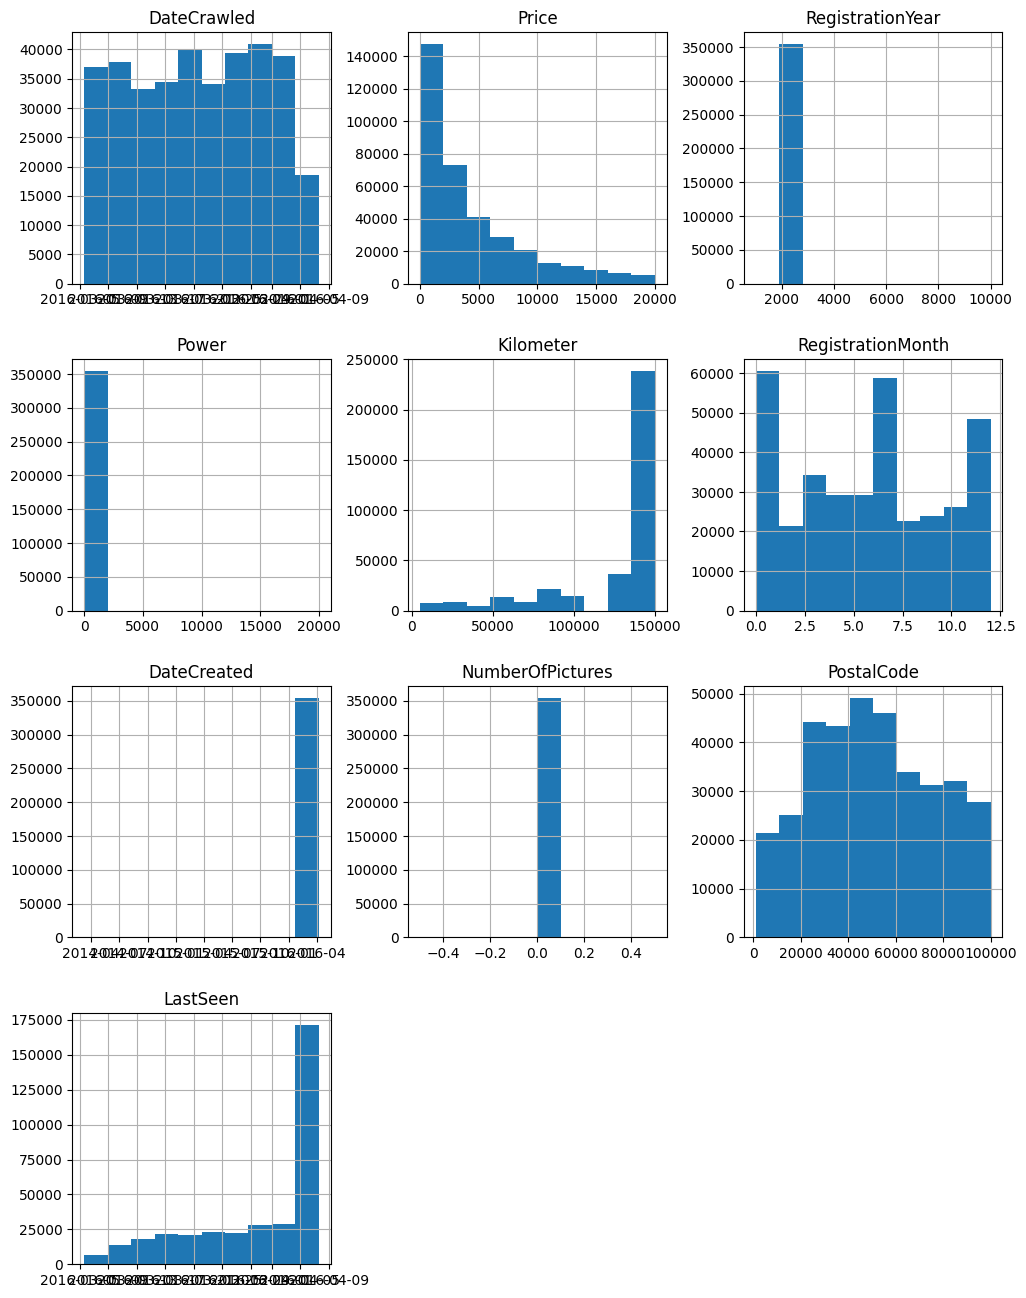

In [13]:
data.hist(bins=10, figsize=(12, 16))
plt.show()

На графиках гистограм есть странности с распределением в некоторых столбцах. Это может быть связано с ошибками в значениях или аномалиями.

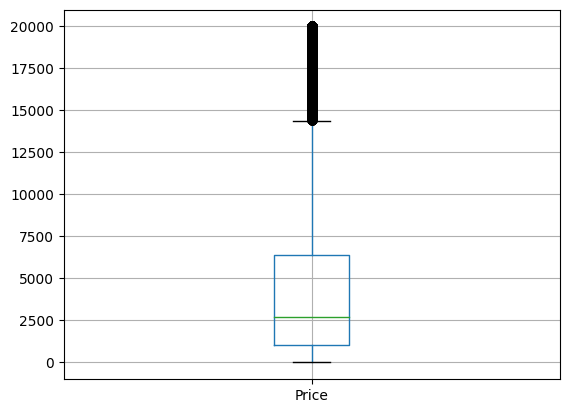

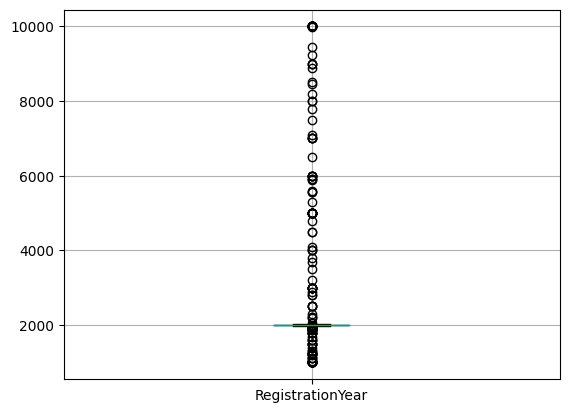

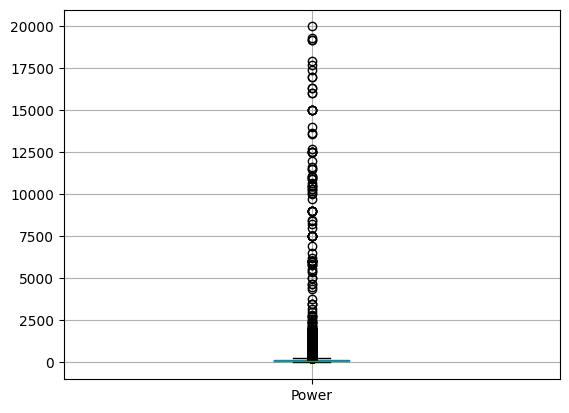

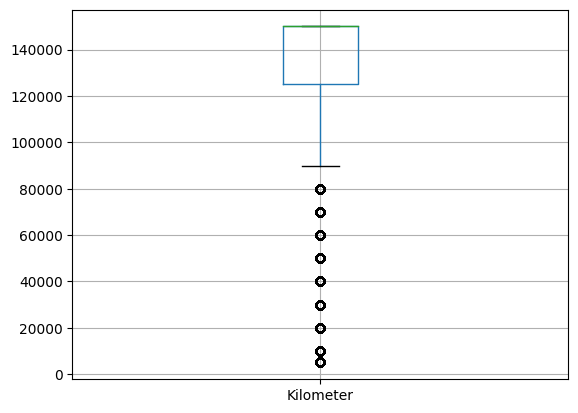

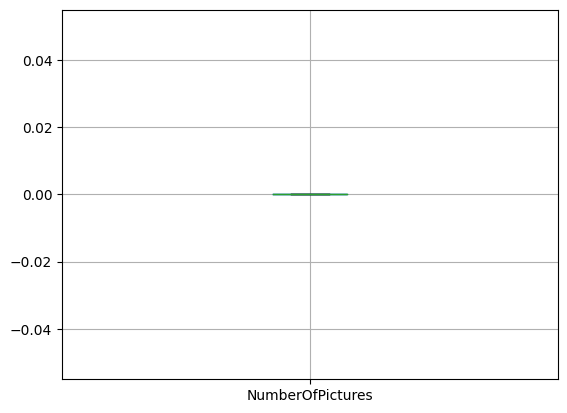

In [14]:
col = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures']
for param in col:
    data.boxplot(column=param)
    plt.show()

Распределение на ящиках с усами показало, что во всех обявлениях отсутствуют фотографии авто. В столбце значений пробега автомобиля тоже всё в порябдке. А вот распределение значений цены, мощности и года регистрации вызывает вопросы. 

Для начала разбиремся с выбросами в столбце года регистрации. На данный момент идёт февраль 2023год, значит года регистрации с более поздней датой являютя ошибкой. Первый серийный автомобиль был выпущен в 1885 году, маловероятно, что такие ретро автомобили будут продаваться через приложение. Ограничим ретро автомобили 1980 годом.

In [15]:
print('Количество строк с явно ошибочным годом:', 
      data.loc[(data['RegistrationYear'] < 1980)|\
               (data['RegistrationYear'] > 2022)]['RegistrationYear']\
               .count())

Количество строк с явно ошибочным годом: 3557


Это 1% выбросов. Удаление такого количества данных не повлияет на исследовани.

In [16]:
data_cl = data.loc[(data['RegistrationYear'] > 1980)&\
                (data['RegistrationYear'] < 2023)]

Теперь рассмотрим мощность автмобилей в подборке. На 2022 год самый мощный двигатель имеет 1500 л.с.. Высокие мощности двигателя не являются частым явлением, поэтому ограничим  более распространненый диапазон( менее 400л.с.).

In [17]:
print('Количество строк с явно ошибочной мощностью:', 
      data_cl.loc[data_cl['Power'] > 400]['RegistrationYear'].count())

Количество строк с явно ошибочной мощностью: 713


In [18]:
data_cl = data_cl.loc[data_cl['Power'] < 400]

Следует отметить наличие нулевых значений в количественных параметрах цены, мощности, месяца регистации, скорее всего они связаны с незаполненными графами, и  0 является заглушкой.

### Связь между данными

Рассмотрим взаимосвязь между целевым признаком и остальными данными.

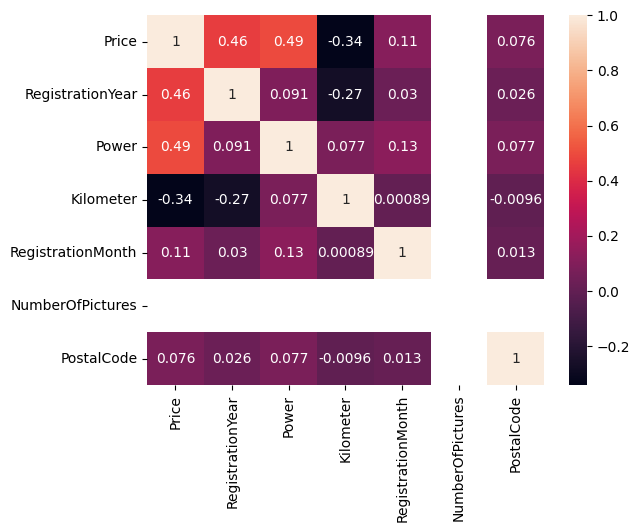

In [19]:
sb.heatmap(data_cl.corr(), annot=True)
plt.show()

По графику корреляции видно, что наш целевой признак(стоимость) имеет сильную положительную линейную связь с годом регистрации и мощностью двигателя и ощутимую отридцательную связь с пробегом.

Теперь можно перейти к исключению неинформативных столбцов - количество фото( так как в данном столбце нет никаких данных),  последняя активность пользователя и дата скачивания анкеты из базы( так как данная взаимосвязь маловероятна).

In [20]:
data_cl = data_cl.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'DateCreated'], axis=1)

### Заполнение пропусков

Вернемся к обработке пропусков, которые были обнаружены ранее.

Данные, в которых одновременно есть пропуски во столбцах с пропусками нельзя считать доставерными, так как это могут быть как ошибочно заполненные объявления, так и возможные ошибки при выгрузке данных. Так как с этими данными будет сложно работать, передадим их для дальнейшего исследования и исключим их из исследуемых данных.

In [21]:
data_cl[data_cl[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isnull().all(1)]\
                .sort_values(by = 'Power', ascending=False)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
37667,8900,NaN,1995,NaN,392,NaN,100000,5,NaN,volkswagen,NaN,88416
166675,0,NaN,2000,NaN,350,NaN,100000,0,NaN,audi,NaN,12679
125438,15500,NaN,2018,NaN,310,NaN,150000,7,NaN,nissan,NaN,24891
349561,10550,NaN,2017,NaN,307,NaN,80000,6,NaN,honda,NaN,36208
255013,7000,NaN,2017,NaN,299,NaN,150000,0,NaN,bmw,NaN,80331
...,...,...,...,...,...,...,...,...,...,...,...,...
118485,3500,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,13127
118426,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,bmw,NaN,77974
118321,1400,NaN,2000,NaN,0,NaN,125000,0,NaN,mazda,NaN,44623
118287,11,NaN,1995,NaN,0,NaN,150000,12,NaN,sonstige_autos,NaN,6618


In [22]:
index_cl = data_cl[data_cl[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']]
                          .isnull().all(1)].index
data_cl = data_cl.drop(index_cl)

Продолжим с информации о ремонте автомобиля и типа коробки передач. Процент пропусков в данных составлял 20% и 5%. Так как информмацию мы не можем предсказать, был ли в ремонте конкретный автомобиль, или какая коробка передач установлена, заменим пропуски на отсутствие данных(unspecified).

In [23]:
data_cl['Repaired'] = data_cl['Repaired'].fillna('unspecified')

In [24]:
data_cl['Gearbox'] = data_cl['Gearbox'].fillna('unspecified')

Теперь рассмотрим пропуски в категории вид топлива.

In [25]:
data_cl['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

В графе есть два идентичных значения 'petrol' и 'gasoline'(оба обозначают бензин). Имеет смысл упразднить и превести к одному обозначению 'petrol'.

In [26]:
data_cl = data_cl.replace({'FuelType':{'gasoline':'petrol'}})

Так как оставшиеся переменные с пропусками являются категориальными введем в них новую категорию, обозначающую незаполненные данные( по аналогии с коничественными признаками, в которых указан 0 в качестве заглушки(цена, месяц регистрации и мощность)).

In [27]:
data_cl = data_cl.fillna('unspecified')

Проверим, не осталось ли пропусков в данных.

In [28]:
data_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347478 entries, 0 to 354364
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              347478 non-null  int64 
 1   VehicleType        347478 non-null  object
 2   RegistrationYear   347478 non-null  int64 
 3   Gearbox            347478 non-null  object
 4   Power              347478 non-null  int64 
 5   Model              347478 non-null  object
 6   Kilometer          347478 non-null  int64 
 7   RegistrationMonth  347478 non-null  int64 
 8   FuelType           347478 non-null  object
 9   Brand              347478 non-null  object
 10  Repaired           347478 non-null  object
 11  PostalCode         347478 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 34.5+ MB


И так, пропусков в данных не осталось, теперь мы можем перейти к разработке моделей.

## Обучение моделей

Для предсказаний рассмотрим 3 модели - линейная регрессия, случайный лес решающих деревьев, и LightGBM. В качестве метрики качества будем использовать RMSE(<2500) и время обучения модели.

Для начала разделим данные на выборки.

In [29]:
features_data = data_cl.drop(['Price'], axis=1)
target_data = data_cl['Price']

In [30]:
features_train, features_valid_test, \
 target_train, target_valid_test = \
              train_test_split(features_data, 
                               target_data,
                               test_size=0.4, 
                               random_state=12345)

In [31]:
features_valid, features_test, \
target_valid, target_test = \
               train_test_split(features_valid_test, 
                                target_valid_test, 
                                test_size=0.5, 
                                random_state=12345)

Скопируем выборки для дальнейшего кодирования

In [32]:
features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

Для обучения простых моделей преобразуем категориальные признаки в числовые. Для этого воспользуемся методом прямого кодирования. Также для повышения точности прогнозов произведем масштабирование признаков.

In [33]:
cat_features = ['VehicleType', 'Gearbox', 
                'Model', 'FuelType', 
                'Brand', 'Repaired']
num_features = ['RegistrationYear', 'Power', 
                'Kilometer', 'RegistrationMonth',
                'PostalCode']

In [36]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-1)
encoder.fit(features_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [37]:
features_train_ord[cat_features] = \
                  encoder.transform(features_train_ord[cat_features])
features_valid_ord[cat_features] = \
                  encoder.transform(features_valid_ord[cat_features])
features_test_ord[cat_features] = \
                  encoder.transform(features_test_ord[cat_features])

In [38]:
scaler = StandardScaler()

scaler.fit(features_train[num_features])

StandardScaler()

In [39]:
features_train_ord[num_features] = \
                  scaler.transform(features_train_ord[num_features])
features_valid_ord[num_features] = \
                  scaler.transform(features_valid_ord[num_features])
features_test_ord[num_features] = \
                  scaler.transform(features_test_ord[num_features])

In [40]:
# функция обучения модели
def model_training(f_tr, t_tr, f_val, t_val, model):
    
   # обучение модели
    start = time.time()
    
    model = model.fit(f_tr, t_tr) 
    fit_time = time.time() - start
    
    start = time.time()
    predict = model.predict(f_val)
    
    predict_time = time.time() - start
    
    rmse = mse(t_val, predict)**0.5
    
    print('Модель обучена. На валлидационной выборке RMSE =', 
          '%.2f' %rmse, '.')
    
    return model, rmse, fit_time, predict_time

In [41]:
def output_to_display(mod, r_mse, t_fit, t_pred):
    print('Модель '+ mod + ' на валлидациооных данных показала' +
          ' следующие результаты:' )
    print('- RMSE =', '%.2f' %r_mse)
    print('- Время обучения модели -', '%.4f' %t_fit, 'с')
    print('- Время предсказания модели -', '%.4f' %t_pred, 'с')

### Линейная регрессия

Обучим модель линейной регрессии.

In [42]:
%%time
model_lr, rmse_lr, t_fit_lr, t_pred_lr = \
            model_training(features_train_ord, target_train,
                           features_valid_ord, target_valid,
                           LinearRegression())

Модель обучена. На валлидационной выборке RMSE = 3110.94 .
CPU times: user 120 ms, sys: 44.3 ms, total: 165 ms
Wall time: 159 ms


In [43]:
output_to_display('линейной регрессии', rmse_lr, t_fit_lr, t_pred_lr)

Модель линейной регрессии на валлидациооных данных показала следующие результаты:
- RMSE = 3110.94
- Время обучения модели - 0.1471 с
- Время предсказания модели - 0.0101 с


Полное время обучения данной модели составило меньше секунды.

### Случайный лес решающих деревьев.

Для обучения данной модели потребуется перебор гипер параметров.

In [44]:
%%time

best_model = None
best_rmse = 10000
best_depth = 0
best_n_est = 0
best_t_fit = 0
best_t_pred = 0
    
for est in range(60, 101, 20):
    for depth in range(16, 21, 2):
        print('Модель случайного леса с', est, \
              'деревьев и глубиной', depth , ':')
        
        model_rfr, rmse_rfr, \
        t_fit_rfr, t_pred_rfr = model_training(features_train_ord, 
                                               target_train,
                                               features_valid_ord,
                                               target_valid,
                                               RandomForestRegressor(
                                                   random_state=12345, 
                                                   n_estimators=est, 
                                                   max_depth=depth))
        
        if rmse_rfr < best_rmse:
            best_rmse = rmse_rfr
            best_model = model_rfr
            best_depth = depth
            best_n_est = est
            best_t_fit = t_fit_rfr
            best_t_pred = t_pred_rfr
            
print('Лучшая модель случайного леса достигнута при', best_n_est, 
                                   'деревьев и глубине', best_depth, '.')

Модель случайного леса с 60 деревьев и глубиной 16 :
Модель обучена. На валлидационной выборке RMSE = 1733.84 .
Модель случайного леса с 60 деревьев и глубиной 18 :
Модель обучена. На валлидационной выборке RMSE = 1711.66 .
Модель случайного леса с 60 деревьев и глубиной 20 :
Модель обучена. На валлидационной выборке RMSE = 1702.27 .
Модель случайного леса с 80 деревьев и глубиной 16 :
Модель обучена. На валлидационной выборке RMSE = 1731.69 .
Модель случайного леса с 80 деревьев и глубиной 18 :
Модель обучена. На валлидационной выборке RMSE = 1708.55 .
Модель случайного леса с 80 деревьев и глубиной 20 :
Модель обучена. На валлидационной выборке RMSE = 1699.36 .
Модель случайного леса с 100 деревьев и глубиной 16 :
Модель обучена. На валлидационной выборке RMSE = 1731.22 .
Модель случайного леса с 100 деревьев и глубиной 18 :
Модель обучена. На валлидационной выборке RMSE = 1707.21 .
Модель случайного леса с 100 деревьев и глубиной 20 :
Модель обучена. На валлидационной выборке RMSE =

Пересохраним показатели лучшей модели в более понятные переменные.

In [45]:
model_rfr = best_model
rmse_rfr = best_rmse
t_fit_rfr = best_t_fit
t_pred_rfr = best_t_pred

In [46]:
output_to_display('случайного леса', rmse_rfr, t_fit_rfr, t_pred_rfr)

Модель случайного леса на валлидациооных данных показала следующие результаты:
- RMSE = 1698.06
- Время обучения модели - 91.8091 с
- Время предсказания модели - 2.7323 с


### LightGBM

Последней моделью рассмотрим LightGBM с градиентным бустингом.

In [47]:
%%time
booster = lgb.LGBMModel(objective="regression", n_estimators=160)
start = time.time()
booster.fit(features_train_ord, target_train, 
            eval_set=[(features_valid_ord, target_valid),], 
            eval_metric="rmse")
t_fit_lgbm = time.time() - start

start = time.time()
valid_preds = booster.predict(features_valid_ord)
t_pred_lgbm = time.time() - start

rmse_lgbm = mse(target_valid, valid_preds)**0.5
print('Модель обучена. На валлидационной выборке RMSE =',
      '%.2f' %rmse_lgbm, '.')

[1]	valid_0's rmse: 4198.12	valid_0's l2: 1.76242e+07
[2]	valid_0's rmse: 3923.14	valid_0's l2: 1.53911e+07
[3]	valid_0's rmse: 3684.61	valid_0's l2: 1.35763e+07
[4]	valid_0's rmse: 3472.57	valid_0's l2: 1.20588e+07
[5]	valid_0's rmse: 3289.12	valid_0's l2: 1.08183e+07
[6]	valid_0's rmse: 3131.92	valid_0's l2: 9.80895e+06
[7]	valid_0's rmse: 2993.3	valid_0's l2: 8.95983e+06
[8]	valid_0's rmse: 2873.22	valid_0's l2: 8.25539e+06
[9]	valid_0's rmse: 2772.15	valid_0's l2: 7.6848e+06
[10]	valid_0's rmse: 2682.12	valid_0's l2: 7.19374e+06
[11]	valid_0's rmse: 2602.71	valid_0's l2: 6.7741e+06
[12]	valid_0's rmse: 2528.66	valid_0's l2: 6.39414e+06
[13]	valid_0's rmse: 2469.83	valid_0's l2: 6.10006e+06
[14]	valid_0's rmse: 2411.84	valid_0's l2: 5.81698e+06
[15]	valid_0's rmse: 2365.58	valid_0's l2: 5.59596e+06
[16]	valid_0's rmse: 2318.94	valid_0's l2: 5.37748e+06
[17]	valid_0's rmse: 2281.03	valid_0's l2: 5.20309e+06
[18]	valid_0's rmse: 2244.75	valid_0's l2: 5.03891e+06
[19]	valid_0's rmse: 2

In [48]:
output_to_display('градиентного бустинга LightGBM', 
                  rmse_lgbm, t_fit_lgbm, t_pred_lgbm)

Модель градиентного бустинга LightGBM на валлидациооных данных показала следующие результаты:
- RMSE = 1766.09
- Время обучения модели - 3.0869 с
- Время предсказания модели - 0.4869 с


Время подбора гиперпараметров этой модели составило меньше минуты. Этот результат гораздо лучше, чем у случайного леса.

## Анализ моделей

Все модели обучены, теперь можно перейти к сравнению полученных данных.

Сведем все полученные данные в одну таблицу. Вреемя в таблице указано для валлидациооной выборки.

In [49]:
pd.DataFrame([
    ['Линейная регрессия', round(rmse_lr, 2),
     round(t_fit_lr, 3), round(t_pred_lr, 3)],
    ['Случайный лес решающих деревьев', round(rmse_rfr, 2),
     round(t_fit_rfr, 3), round(t_pred_rfr, 3)],
    ['Градиентный бустинг', round(rmse_lgbm, 2),
     round(t_fit_lgbm, 3), round(t_pred_lgbm, 3)],
              ], 
             columns=['Модель', 'RMSE',
                      'Время обучения(c)', 
                      'Время предсказания(c)'])

,Модель,RMSE,Время обучения(c),Время предсказания(c)
0,Линейная регрессия,3110.94,0.147,0.010
1,Случайный лес решающих деревьев,1698.06,91.809,2.732
2,Градиентный бустинг,1766.09,3.087,0.487


Самая высокая точность предлсказаний оказалась у модели случайного леса решающих деревьев. А вот лучшее время обучения и предсказания показывает модель линейной регрессии, однако качество данной модели самое низкое и не соответствует условию RMSE < 2500.

Также не стоит забывать и про время подбора гипер параметров. Поэтому оптимальной моделью оказывется градиентный бустинг. Точность предсказаний немного ниже, чем у случайного леса, но при этом скорость предсказаний значительно выше, как и время подбора гиперпараметров.

## Проверка выбранной модели

Проверим выбранную модель на тестовой выборке.

In [50]:
start = time.time()
test_preds = booster.predict(features_test_ord)
t_pred_test = time.time() - start

rmse_test = mse(target_test, test_preds)**0.5

In [51]:
pd.DataFrame([
    ['Валлидационная выборка', round(rmse_lgbm, 2), round(t_pred_lgbm, 3)],
    ['Тестовая выборка', round(rmse_test, 2), round(t_pred_test, 3)],
              ],
              columns=['Выборка', 'RMSE', 'Время предсказания(c)'])

,Выборка,RMSE,Время предсказания(c)
0,Валлидационная выборка,1766.09,0.487
1,Тестовая выборка,1763.67,0.475


Качество предсказаний на тестовой выборке практически не меняется, но всё ещё в перделах допустимого. а вот время предсказаний даже улучшилось. Сравним распределение полученных значений и фактических.

График распределения значений 


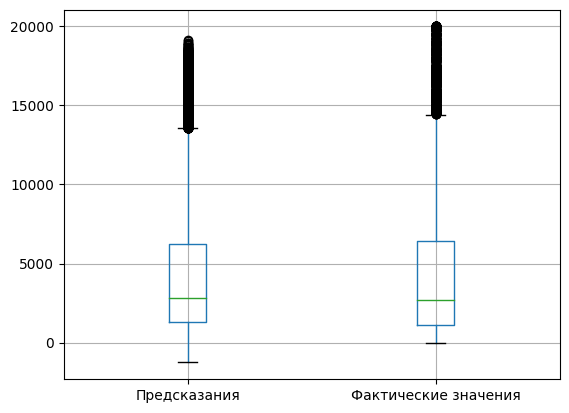

In [52]:
tester = pd.DataFrame()
tester['Предсказания'] = test_preds
tester['Фактические значения'] = target_test
print('График распределения значений ')
tester.boxplot(column=['Предсказания', 'Фактические значения'])
plt.show()

По грфику распределения можно видеть, что предсказания имеют более скученные значения, чем исходные, в остальном значения предсказаний на тестовой выборке достаточно близки к исходным значениям.

## Вывод

На основании данных сервиса по продаже автомобилей с пробегом «Не бит, не крашен»была проведена разработка модели для определения стоимости автомобиля для дальнейшего использования в новом приложении с целью привлечения новых клиентов.

В рамках работы было проведено исследование полученных данных. На основании проведенного анализа, рекомендовано добавить автоматическое заполнение "не выбрано" для столбцов свединях о ремонте, тип кузова, тип топлива, коробка передач, бренд и модель автомобиля. Рекомендация дана для возможности исключения случайных ошибок.

Для потенциальной модели предсказаний были выбраны модель линейной регрессии, случайный лес решающих деревьев и градиентный бустинг. Мной были получены следующие показатели:

| модель |RMSE | Время обучения| Время предсказания | Время подбора параметров|
|:-------|:---:|:-------------:|:------------------:|:-----------------------:|
|Линейная регрессия	| 3110.94 | 0.147 с | 0.010 с | - |
|Случайный лес | 1698.06 | 91.809 c	| 2.732 c| 10.5 мин. |
|Градиентный бустинг | 1766.09 | 3.087 c| 0.487 c| 7 с|

На основании этих данных был сделан вывод, что оптимальной из обученных моделей, являестся модель, обученная с использованием градиентного бустига. 

Затем, обученная модель была проверена на тестовой выборке. На тестовых данных было небольшое снижение качества предсказаний, но время предсказания практически не изменилось. Поэтому данная модель готова к использованию.

**Дополнительно** Настоятельно рекомендовано рассмотреть возможность в приложении не давать возможность предложения стоимости автомобиля без заполнения основных параметров, так как это увеличит точность работы Вашего сервиса, что в свою очередь повысит доверие клиентов.